In [1]:
%reload_ext autotime

import os
import numpy as np
import pickle
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
from scipy import interpolate
from scipy import stats
from datetime import datetime, timedelta
import pytz
from coastsat import SDS_download, SDS_preprocess, SDS_shoreline, SDS_tools, SDS_transects
import geopandas as gpd
import tqdm.auto as tqdm
from glob import glob
import ee
from shapely.ops import split
from shapely import line_merge
from matplotlib_venn import venn2
import matplotlib.pyplot as plt
import pyfes
import contextily as cx
cx.set_cache_dir("tile_cache")

In [2]:
service_account = "service-account@iron-dynamics-294100.iam.gserviceaccount.com"
credentials = ee.ServiceAccountCredentials(service_account, ".private-key.json")
ee.Initialize(credentials)

In [110]:
sitename = "ber0001"

In [111]:
poly = gpd.read_file("polygons.geojson")
poly = poly[poly.id == sitename]
poly.set_index("id", inplace=True)
poly

area id_sorted  northing  \
id                                  
ber0001   NaN      None       NaN   

                                                  geometry  
id                                                          
ber0001  POLYGON ((-64.87425 32.30383, -64.87087 32.306...

In [112]:
inputs = {
    "polygon": list(poly.geometry[sitename].exterior.coords),
    "dates": ["1998-01-01", "2030-12-30"],  # All available imagery
    "sat_list": ["L5", "L7", "L8", "L9"],
    "sitename": sitename,
    "filepath": "data",
    "landsat_collection": "C02",
}
#result = SDS_download.check_images_available(inputs)

In [113]:
#metadata = SDS_download.retrieve_images(inputs)
metadata = SDS_download.get_metadata(inputs)

In [114]:
shorelines = gpd.read_file("shorelines.geojson")
# shorelines = shorelines[shorelines.id.str.startswith("nzd")]
shorelines.set_index("id", inplace=True)
shorelines

area       beach_length            easting    name  \
id                                                                         
aus0001  14472901.48412414  16824.52342226356  526589.1754011525  noname   
aus0002  53438721.70867591  16794.63203331262  529484.7418874454  noname   
aus0003  945965.0455573548   1373.06418305453  535380.0262458471  noname   
aus0004  376936.0048626679  253.8720097247056  535397.4773649719  noname   
aus0005  1570125.540326883  1830.166677525537  535675.2172291321  noname   
...                    ...                ...                ...     ...   
sar2539               None  324.3747233912443               None    None   
sar2540               None               None               None    None   
sar2541               None               None               None    None   
ber0001               None               None               None    None   
ber0002               None               None               None    None   

                  northing  Tide range  median_orientation id_sorted  \
id                                                                     
aus0001  7259734.061377056       1.451           92.466545   aus0001   
aus0002  7243833.021796449       1.073           64.603602   aus0002   
aus0003  7237842.578773651       1.074           93.116374   aus0003   
aus0004  7236435.680204276       1.074           79.203813   aus0004   
aus0005  7235101.123683789       1.074           74.946714   aus0005   
...                    ...         ...                 ...       ...   
sar2539               None         NaN                 NaN      None   
sar2540               None         NaN                 NaN      None   
sar2541               None         NaN                 NaN      None   
ber0001               None         NaN                 NaN      None   
ber0002               None         NaN                 NaN      None   

        same_beach  median_slope      ci  n_points  n_points_nonan  \
id                                                                   
aus0001       None      0.076702  0.0214     654.0           520.0   
aus0002          1      0.059681  0.0203     579.0           407.0   
aus0003       None      0.041382  0.0112     335.0           243.0   
aus0004       None      0.051540  0.0154     319.0           238.0   
aus0005       None      0.054151  0.0245     307.0           231.5   
...            ...           ...     ...       ...             ...   
sar2539       None           NaN     NaN       NaN             NaN   
sar2540       None           NaN     NaN       NaN             NaN   
sar2541       None           NaN     NaN       NaN             NaN   
ber0001       None           NaN     NaN       NaN             NaN   
ber0002       None           NaN     NaN       NaN             NaN   

                                                  geometry  
id                                                          
aus0001  LINESTRING (153.26746 -24.70115, 153.26743 -24...  
aus0002  LINESTRING (153.26189 -24.85277, 153.26191 -24...  
aus0003  LINESTRING (153.35089 -24.96818, 153.35075 -24...  
aus0004  LINESTRING (153.35051 -24.98595, 153.35099 -24...  
aus0005  LINESTRING (153.35161 -24.99115, 153.35228 -24...  
...                                                    ...  
sar2539  LINESTRING (9.40097 41.30191, 9.40103 41.30189...  
sar2540  LINESTRING (8.77991 38.91331, 8.78042 38.91311...  
sar2541  LINESTRING (8.85393 38.87871, 8.85426 38.8787,...  
ber0001  LINESTRING (295.12724 32.30374, 295.12884 32.3...  
ber0002  LINESTRING (295.17735 32.25079, 295.17762 32.2...  

[5691 rows x 14 columns]

In [115]:
# settings for the shoreline extraction
settings = {
    # general parameters:
    "cloud_thresh": 0.1,  # threshold on maximum cloud cover
    "dist_clouds": 300,  # ditance around clouds where shoreline can't be mapped
    "output_epsg": 3769,  # epsg code of spatial reference system desired for the output
    # quality control:
    "check_detection": False,  # if True, shows each shoreline detection to the user for validation
    "adjust_detection": False,  # if True, allows user to adjust the postion of each shoreline by changing the threhold
    "save_figure": True,  # if True, saves a figure showing the mapped shoreline for each image
    # [ONLY FOR ADVANCED USERS] shoreline detection parameters:
    "min_beach_area": 1000,  # minimum area (in metres^2) for an object to be labelled as a beach
    "min_length_sl": 500,  # minimum length (in metres) of shoreline perimeter to be valid
    "cloud_mask_issue": True,  # switch this parameter to True if sand pixels are masked (in black) on many images
    "sand_color": "default",  # 'default', 'latest', 'dark' (for grey/black sand beaches) or 'bright' (for white sand beaches)
    "pan_off": False,  # True to switch pansharpening off for Landsat 7/8/9 imagery
    "s2cloudless_prob": 40,  # threshold to identify cloud pixels in the s2cloudless probability mask
    # add the inputs defined previously
    "inputs": inputs,
}

# [OPTIONAL] preprocess images (cloud masking, pansharpening/down-sampling)
#SDS_preprocess.save_jpg(metadata, settings, use_matplotlib=True)

In [116]:
transects_gdf = gpd.read_file("transects_extended.geojson")
transects_gdf.set_index("id", inplace=True)
transects_gdf = transects_gdf[transects_gdf.site_id == sitename]
display(transects_gdf)
transects = {}
for transect_id in transects_gdf.index:
    transects[transect_id] = np.array(
        transects_gdf.geometry.to_crs(settings["output_epsg"])[transect_id].coords
    )
transects

site_id  orientation  along_dist  along_dist_norm  beach_slope  \
id                                                                             
ber0001-0000  ber0001          NaN         NaN              NaN        0.200   
ber0001-0001  ber0001          NaN         NaN              NaN        0.185   
ber0001-0002  ber0001          NaN         NaN              NaN        0.200   
ber0001-0003  ber0001          NaN         NaN              NaN        0.200   
ber0001-0004  ber0001          NaN         NaN              NaN        0.200   
ber0001-0005  ber0001          NaN         NaN              NaN        0.175   
ber0001-0006  ber0001          NaN         NaN              NaN        0.110   
ber0001-0007  ber0001          NaN         NaN              NaN        0.090   
ber0001-0008  ber0001          NaN         NaN              NaN        0.165   
ber0001-0009  ber0001          NaN         NaN              NaN        0.135   

                 cil     ciu     trend  n_points  n_points_nonan  r2_score  \
id                                                                           
ber0001-0000  0.1135  0.2000 -0.056208     232.0            69.0  0.002363   
ber0001-0001  0.0798  0.2000 -0.078000     232.0            71.0  0.004105   
ber0001-0002  0.1169  0.2000 -0.018693     232.0            71.0  0.000215   
ber0001-0003  0.1257  0.2000  0.206748     232.0            72.0  0.023399   
ber0001-0004  0.1000  0.2000  0.167038     232.0            72.0  0.013311   
ber0001-0005  0.0907  0.2000  0.139066     232.0            71.0  0.014240   
ber0001-0006  0.0714  0.2000  0.151685     232.0            71.0  0.017228   
ber0001-0007  0.0598  0.1725  0.071970     232.0            70.0  0.004316   
ber0001-0008  0.0881  0.2000 -0.269111     232.0            71.0  0.055752   
ber0001-0009  0.0883  0.2000 -0.350871     232.0            71.0  0.069980   

                   mae        mse      rmse   intercept ERODIBILITY  \
id                                                                    
ber0001-0000  4.375736  27.222509  5.217519  170.512247        None   
ber0001-0001  4.250217  30.419051  5.515347  163.856663        None   
ber0001-0002  4.455130  33.485554  5.786670  161.618501        None   
ber0001-0003  4.286765  37.474085  6.121608  157.194883        None   
ber0001-0004  4.518156  43.443083  6.591137  158.325913        None   
ber0001-0005  3.839382  27.655792  5.258877  157.233840        None   
ber0001-0006  4.037084  27.113502  5.207063  154.499954        None   
ber0001-0007  3.556516  24.891431  4.989131  158.660779        None   
ber0001-0008  3.564831  25.338244  5.033711  170.540171        None   
ber0001-0009  4.379646  33.798802  5.813674  171.836844        None   

                                                       geometry  
id                                                               
ber0001-0000  LINESTRING (-64.8718 32.30266, -64.87371 32.30...  
ber0001-0001  LINESTRING (-64.87159 32.30279, -64.8735 32.30...  
ber0001-0002  LINESTRING (-64.87138 32.30293, -64.87328 32.3...  
ber0001-0003  LINESTRING (-64.87116 32.30306, -64.87307 32.3...  
ber0001-0004  LINESTRING (-64.87095 32.3032, -64.87286 32.30...  
ber0001-0005  LINESTRING (-64.87074 32.30333, -64.87265 32.3...  
ber0001-0006  LINESTRING (-64.87053 32.30347, -64.87243 32.3...  
ber0001-0007  LINESTRING (-64.87031 32.3036, -64.87222 32.30...  
ber0001-0008  LINESTRING (-64.86968 32.30425, -64.87252 32.3...  
ber0001-0009  LINESTRING (-64.86956 32.30445, -64.8724 32.30...

{'ber0001-0000': array([[ 323735.84372824, 3575178.42936627],
        [ 323560.50722808, 3575421.8572019 ]]),
 'ber0001-0001': array([[ 323756.13124111, 3575193.04689095],
        [ 323580.78645861, 3575436.46876074]]),
 'ber0001-0002': array([[ 323776.41047164, 3575207.65844979],
        [ 323601.07397148, 3575451.08628542]]),
 'ber0001-0003': array([[ 323796.73981807, 3575222.30611948],
        [ 323621.31136844, 3575465.66769924]]),
 'ber0001-0004': array([[ 323817.02733086, 3575236.92364647],
        [ 323641.59059905, 3575480.27925577]]),
 'ber0001-0005': array([[ 323837.26472791, 3575251.50505798],
        [ 323661.9199454 , 3575494.92692777]]),
 'ber0001-0006': array([[ 323857.54395843, 3575266.11661682],
        [ 323682.20745828, 3575509.54445245]]),
 'ber0001-0007': array([[ 323877.82733013, 3575280.73115858],
        [ 323702.49082998, 3575524.15899421]]),
 'ber0001-0008': array([[ 323939.13283408, 3575351.03188031],
        [ 323673.4244003 , 3575490.31227337]]),
 'ber0001-

In [117]:
ref_sl = np.array(
    line_merge(
        split(
            shorelines.geometry.to_crs(settings["output_epsg"])[sitename],
            transects_gdf.to_crs(settings["output_epsg"]).unary_union,
        )
    ).coords
)
ref_sl

array([[ 323648.17957863, 3575300.14292435],
       [ 323668.46042147, 3575314.75564406],
       [ 323688.74379308, 3575329.37018579],
       [ 323709.02716558, 3575343.98472817],
       [ 323729.31053734, 3575358.59927   ],
       [ 323749.5939082 , 3575373.21381119],
       [ 323769.87727981, 3575387.82835292],
       [ 323790.16065149, 3575402.4428947 ],
       [ 323800.71319641, 3575410.04619711],
       [ 323806.28198168, 3575420.67031322],
       [ 323817.88832508, 3575442.8128693 ],
       [ 323819.03172511, 3575444.99424532]])

In [118]:
settings["max_dist_ref"] = 300
settings["reference_shoreline"] = ref_sl #np.flip(ref_sl)

In [119]:
output = SDS_shoreline.extract_shorelines(metadata, settings)

L5: Mapping Shorelines:   0%|          | 0/14 [00:00<?, ?it/s]

L7: Mapping Shorelines:   0%|          | 0/110 [00:00<?, ?it/s]

L8: Mapping Shorelines:   0%|          | 0/154 [00:00<?, ?it/s]

L8 2024-02-16-14-52-29: Could not map shoreline due to error no valid pixels found in reference shoreline buffer.
L8 2024-11-30-14-52-36: Could not map shoreline due to error no valid pixels found in reference shoreline buffer.


L9: Mapping Shorelines:   0%|          | 0/59 [00:00<?, ?it/s]

L9 2023-04-26-14-52-12: Could not map shoreline due to error no valid pixels found in reference shoreline buffer.
L9 2023-05-12-14-52-03: Could not map shoreline due to error no valid pixels found in reference shoreline buffer.
L9 2025-05-17-14-51-57: Could not map shoreline due to error no valid pixels found in reference shoreline buffer.


In [120]:
output = SDS_tools.remove_duplicates(
    output
)  # removes duplicates (images taken on the same date by the same satellite)
output = SDS_tools.remove_inaccurate_georef(
    output, 10
)  # remove inaccurate georeferencing (set threshold to 10 m)

7 duplicates
0 bad georef


In [121]:
from pyproj import CRS

geomtype = "lines"  # choose 'points' or 'lines' for the layer geometry
gdf = SDS_tools.output_to_gdf(output, geomtype)
if gdf is None:
    raise Exception("output does not contain any mapped shorelines")
gdf.crs = CRS(settings["output_epsg"])  # set layer projection
# save GEOJSON layer to file
gdf.to_file(
    os.path.join(
        inputs["filepath"],
        inputs["sitename"],
        "%s_output_%s_latest.geojson" % (sitename, geomtype),
    ),
    driver="GeoJSON",
    encoding="utf-8",
)

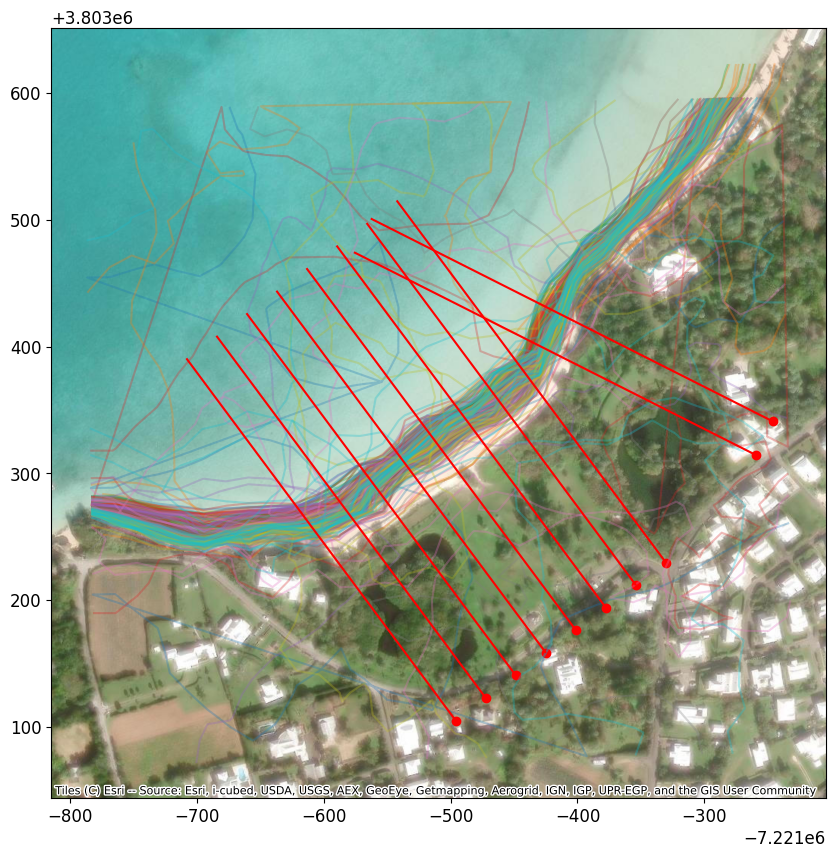

In [122]:
ax = gdf.to_crs(3857).plot("date", figsize=(10,10), alpha=.3)
transects_gdf.to_crs(3857).plot(ax=ax, color="red")
from shapely.geometry import Point
gpd.GeoSeries(transects_gdf.geometry.apply(lambda line: Point(line.coords[0])), crs=transects_gdf.crs).to_crs(3857).plot(ax=ax, color="red")
cx.add_basemap(ax, source=cx.providers.Esri.WorldImagery)
plt.show()

In [123]:
settings_transects = {  # parameters for computing intersections
    "along_dist": 25,  # along-shore distance to use for computing the intersection
    "min_points": 3,  # minimum number of shoreline points to calculate an intersection
    "max_std": 15,  # max std for points around transect
    "max_range": 30,  # max range for points around transect
    "min_chainage": -100,  # largest negative value along transect (landwards of transect origin)
    "multiple_inter": "auto",  # mode for removing outliers ('auto', 'nan', 'max')
    "auto_prc": 0.1,  # percentage of the time that multiple intersects are present to use the max
}
cross_distance = SDS_transects.compute_intersection_QC(
    output, transects, settings_transects
)

Computing transect shoreline intersections:   0%|          | 0/10 [00:00<?, ?it/s]

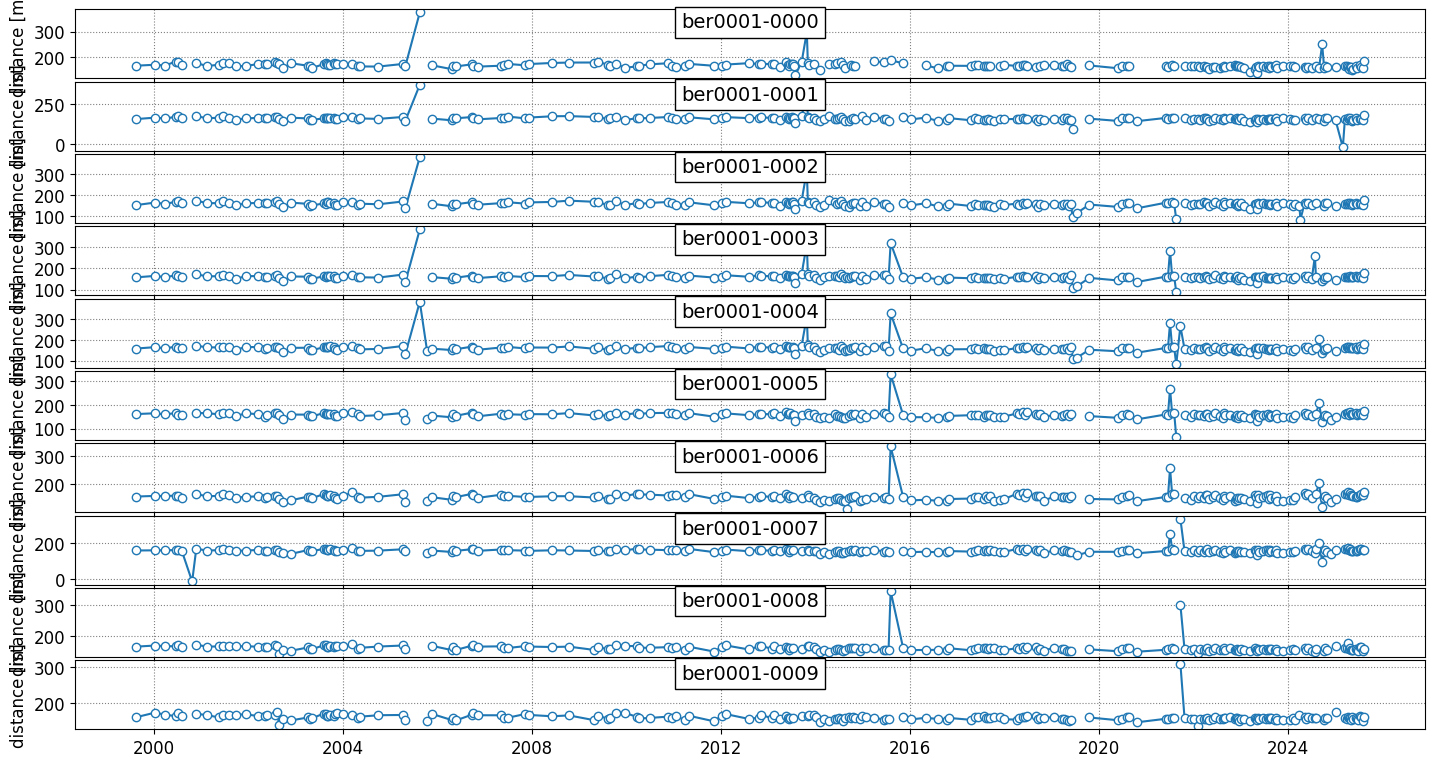

In [124]:
fig = plt.figure(figsize=[15, 8], tight_layout=True)
gs = gridspec.GridSpec(len(cross_distance), 1)
gs.update(left=0.05, right=0.95, bottom=0.05, top=0.95, hspace=0.05)
for i, key in enumerate(cross_distance.keys()):
    if np.all(np.isnan(cross_distance[key])):
        continue
    ax = fig.add_subplot(gs[i, 0])
    ax.grid(linestyle=":", color="0.5")
    ax.plot(output["dates"], cross_distance[key], "-o", ms=6, mfc="w")
    ax.set_ylabel("distance [m]", fontsize=12)
    ax.text(
        0.5,
        0.95,
        key,
        bbox=dict(boxstyle="square", ec="k", fc="w"),
        ha="center",
        va="top",
        transform=ax.transAxes,
        fontsize=14,
    )
plt.show()

In [125]:
# save a .csv file for Excel users
out_dict = dict([])
out_dict["dates"] = output["dates"]
out_dict["satname"] = output["satname"]
for key in transects.keys():
    out_dict[key] = cross_distance[key]
df = pd.DataFrame(out_dict)
fn = os.path.join(
    settings["inputs"]["filepath"],
    settings["inputs"]["sitename"],
    "transect_time_series.csv",
)
df.to_csv(fn, sep=',', index=False)
print('Time-series of the shoreline change along the transects saved as:\n%s'%fn)
df

Time-series of the shoreline change along the transects saved as:
data/ber0001/transect_time_series.csv


dates satname  ber0001-0000  ber0001-0001  \
0   1999-08-14 14:45:41+00:00      L7    165.078259    155.511675   
1   2000-01-05 14:45:38+00:00      L7    168.811383    164.427360   
2   2000-03-25 14:45:24+00:00      L7    165.622408    159.624406   
3   2000-06-13 14:44:40+00:00      L7    181.607537    169.017747   
4   2000-06-29 14:44:28+00:00      L7    178.595271    177.648137   
..                        ...     ...           ...           ...   
232 2025-06-26 14:52:33+00:00      L8           NaN           NaN   
233 2025-07-12 14:52:36+00:00      L8    165.873522    153.649229   
234 2025-07-20 14:52:39+00:00      L9    161.679995    153.448623   
235 2025-07-28 14:52:42+00:00      L8    157.739381    150.125135   
236 2025-08-05 14:52:46+00:00      L9    184.214769    183.156450   

     ber0001-0002  ber0001-0003  ber0001-0004  ber0001-0005  ber0001-0006  \
0      152.437167    158.000583    158.709140    161.502661    157.482853   
1      164.411617    164.772548    165.223103    164.793881    159.671628   
2      157.678879    158.960897    159.528142    160.080082    159.510967   
3      168.128489    166.951295    167.595570    165.811994    160.654349   
4      174.233689    164.587177    162.879494    157.804511    159.179955   
..            ...           ...           ...           ...           ...   
232           NaN    159.600170    159.606482    160.984664    161.106440   
233    156.684638    164.353009    169.129696    165.961022    163.008914   
234    157.824313    158.206583    158.962010    163.146812    165.878834   
235    154.432784    154.666964    156.571870    158.565755    163.762006   
236    178.527511    178.531532    180.451765    173.898593    172.579581   

     ber0001-0007  ber0001-0008  ber0001-0009  
0      159.384478    166.211093    161.708263  
1      160.005556    169.668805    174.331114  
2      160.827155    167.779602    168.714283  
3      161.615757    167.326275    164.726751  
4      163.537767    171.552548    173.800131  
..            ...           ...           ...  
232    161.127734    153.571297    152.644904  
233    167.753907    165.526803    164.294244  
234    168.553502    165.469010    161.723033  
235    163.758103    153.108486    152.496540  
236    162.886534    159.488232    163.014659  

[237 rows x 12 columns]

In [20]:
handlers = pyfes.load_config("fes2022b/fes2022.yaml")

In [126]:
centroid = np.array(poly.geometry.centroid[0].coords[0])
# if longitude is negative add 180 (longitudes are from 0 to 360 in fes)
if centroid[0] < 0: centroid[0] += 360
centroid

array([295.12819044,  32.30435934])

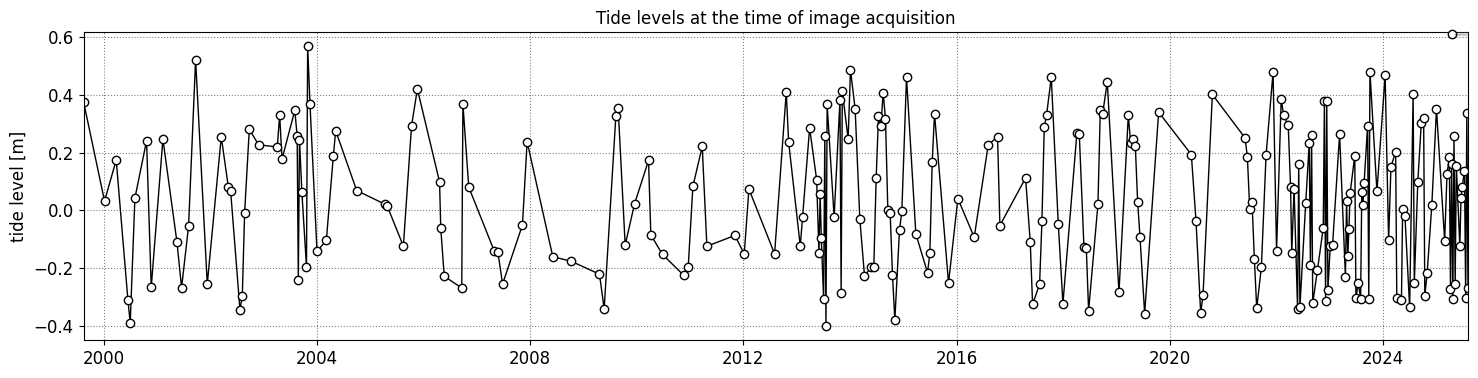

In [127]:
ocean_tide = handlers['tide']
load_tide = handlers['radial']
import SDS_slope

timestep = 900 # in seconds

# get tide levels corresponding to the time of image acquisition
dates_sat = output['dates']
tides_sat = SDS_slope.compute_tide_dates(centroid, output['dates'], ocean_tide, load_tide)
# plot the subsampled tide data
fig, ax = plt.subplots(1,1,figsize=(15,4), tight_layout=True)
ax.grid(which='major', linestyle=':', color='0.5')
ax.plot(dates_sat, tides_sat, '-o', color='k', ms=6, mfc='w',lw=1, label='image acquisition')
ax.set(ylabel='tide level [m]',xlim=[dates_sat[0],dates_sat[-1]], title='Tide levels at the time of image acquisition');
ax.legend()
filepath = os.path.join(inputs['filepath'], sitename)
fig.savefig(os.path.join(filepath,'%s_tide_timeseries.jpg'%sitename),dpi=200)
fig

In [128]:
tides = pd.DataFrame({'dates':dates_sat,'tide':tides_sat})
tides.to_csv(os.path.join(filepath,'tides.csv'),index=False)
tides

dates      tide
0   1999-08-14 14:45:41+00:00  0.375919
1   2000-01-05 14:45:38+00:00  0.032308
2   2000-03-25 14:45:24+00:00  0.174229
3   2000-06-13 14:44:40+00:00 -0.307922
4   2000-06-29 14:44:28+00:00 -0.388794
..                        ...       ...
232 2025-06-26 14:52:33+00:00  0.082160
233 2025-07-12 14:52:36+00:00  0.136967
234 2025-07-20 14:52:39+00:00 -0.300972
235 2025-07-28 14:52:42+00:00  0.335843
236 2025-08-05 14:52:46+00:00 -0.266376

[237 rows x 2 columns]

In [129]:
df.index = pd.to_datetime(df.dates)
df.drop(columns=["dates", "satname"], inplace=True)

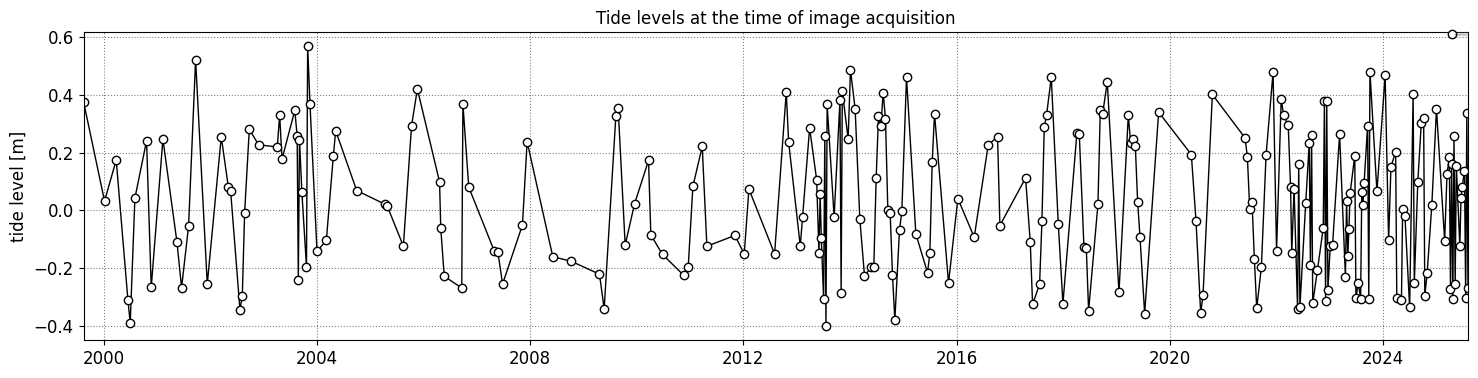

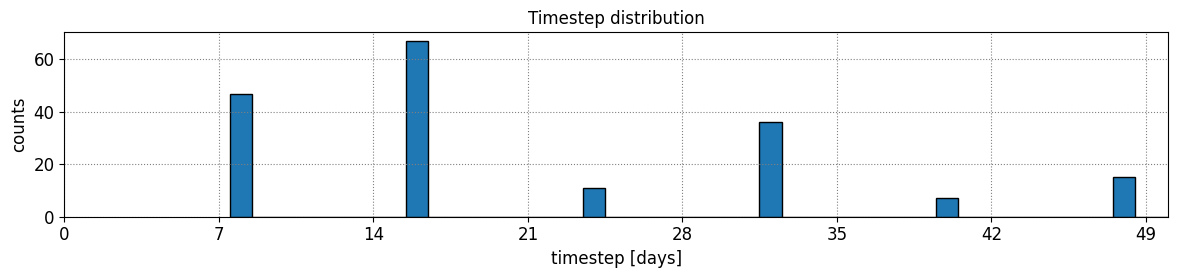

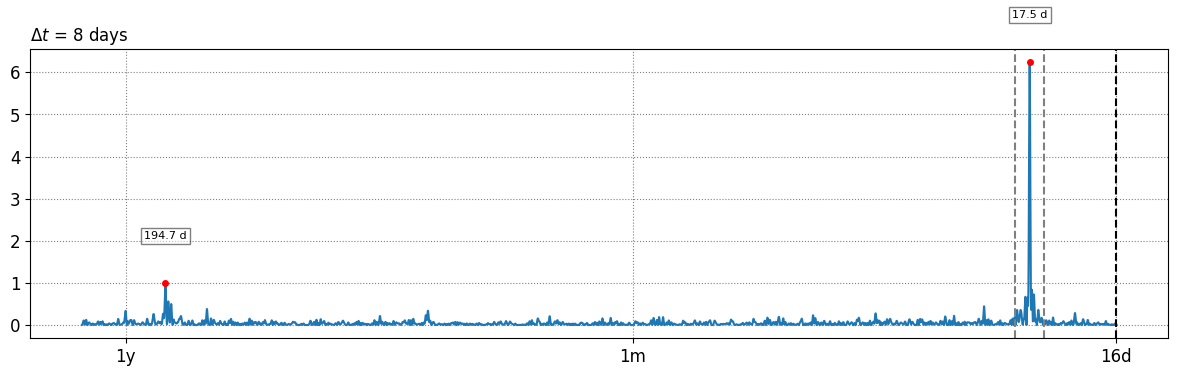

In [130]:
days_in_year = 365.2425
seconds_in_day = 24*3600
settings_slope = {'slope_min':        0.01,                  # minimum slope to trial
                  'slope_max':        0.2,                    # maximum slope to trial
                  'delta_slope':      0.005,                  # slope increment
                  'date_range':       [1999,2020],            # range of dates over which to perform the analysis
                  'n_days':           8,                      # sampling period [days]
                  'n0':               50,                     # parameter for Nyquist criterium in Lomb-Scargle transforms
                  'freqs_cutoff':     1./(seconds_in_day*30), # 1 month frequency
                  'delta_f':          100*1e-10,              # deltaf for identifying peak tidal frequency band
                  'prc_conf':         0.05,                   # percentage above minimum to define confidence bands in energy curve
                  }
settings_slope['date_range'] = [pytz.utc.localize(datetime(settings_slope['date_range'][0],5,1)),
                                pytz.utc.localize(datetime(settings_slope['date_range'][1],1,1))]
beach_slopes = SDS_slope.range_slopes(settings_slope['slope_min'], settings_slope['slope_max'], settings_slope['delta_slope'])

t = np.array([_.timestamp() for _ in df.index]).astype('float64')
delta_t = np.diff(t)
fig, ax = plt.subplots(1,1,figsize=(12,3), tight_layout=True)
ax.grid(which='major', linestyle=':', color='0.5')
bins = np.arange(np.min(delta_t)/seconds_in_day, np.max(delta_t)/seconds_in_day+1,1)-0.5
ax.hist(delta_t/seconds_in_day, bins=bins, ec='k', width=1);
ax.set(xlabel='timestep [days]', ylabel='counts',
      xticks=7*np.arange(0,20),
      xlim=[0,50], title='Timestep distribution');

# find tidal peak frequency (can choose 7 or 8 in this case)
settings_slope['n_days'] = 8
settings_slope['freqs_max'] = SDS_slope.find_tide_peak(df.index,tides.tide,settings_slope)
plt.show()

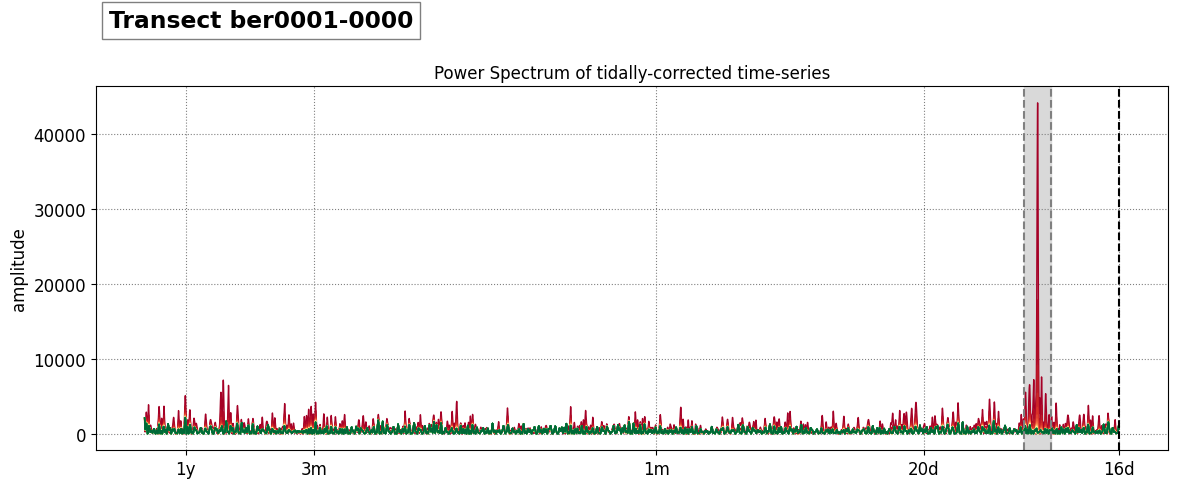

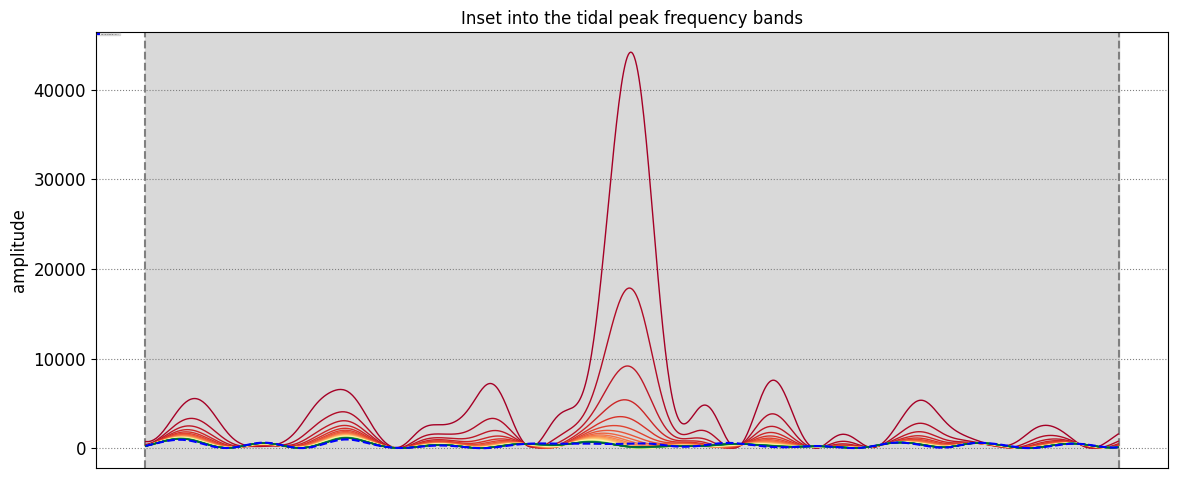

Beach slope at transect ber0001-0000: 0.200 (0.1130 - 0.2000)


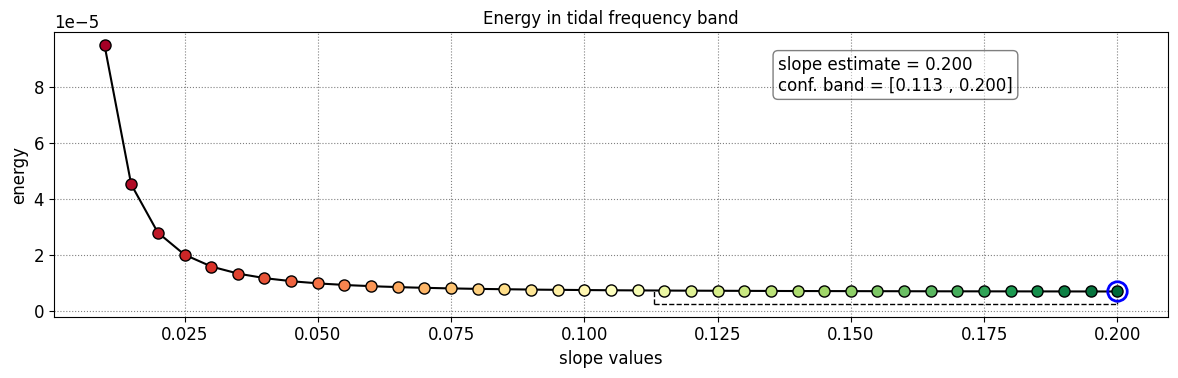

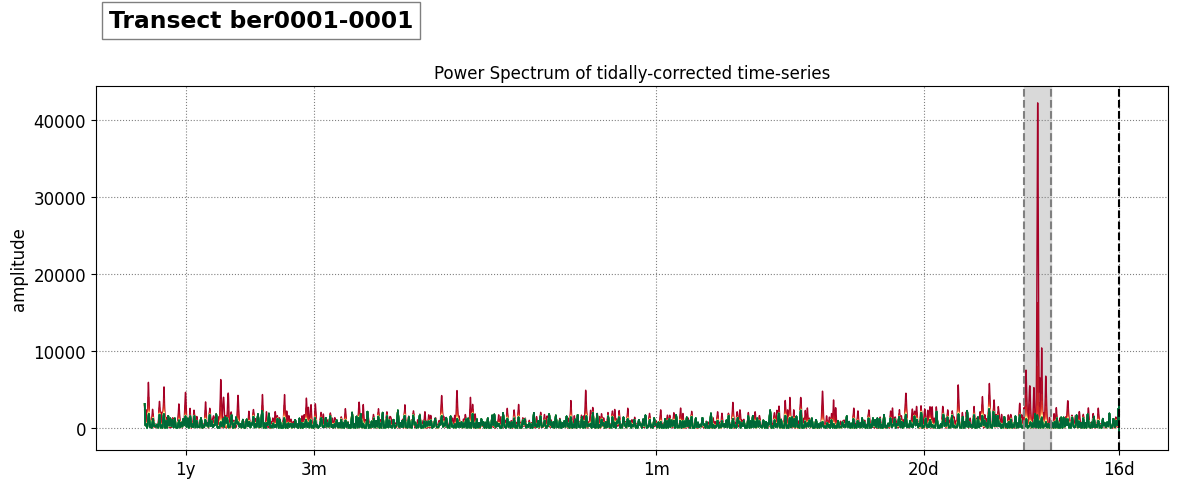

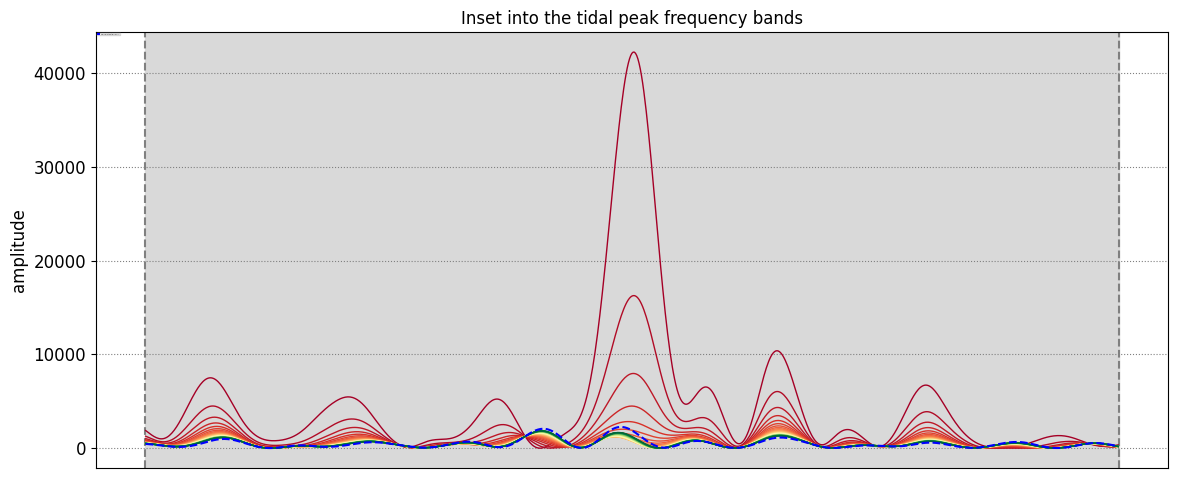

Beach slope at transect ber0001-0001: 0.185 (0.0802 - 0.2000)


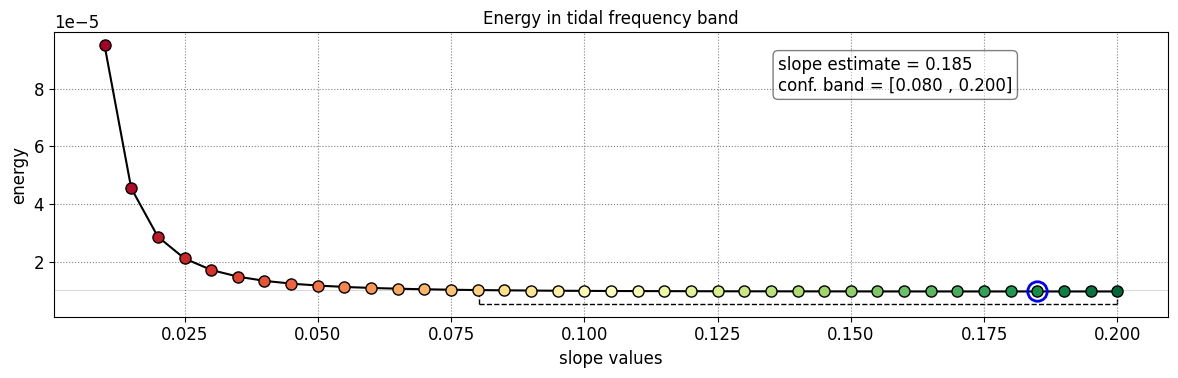

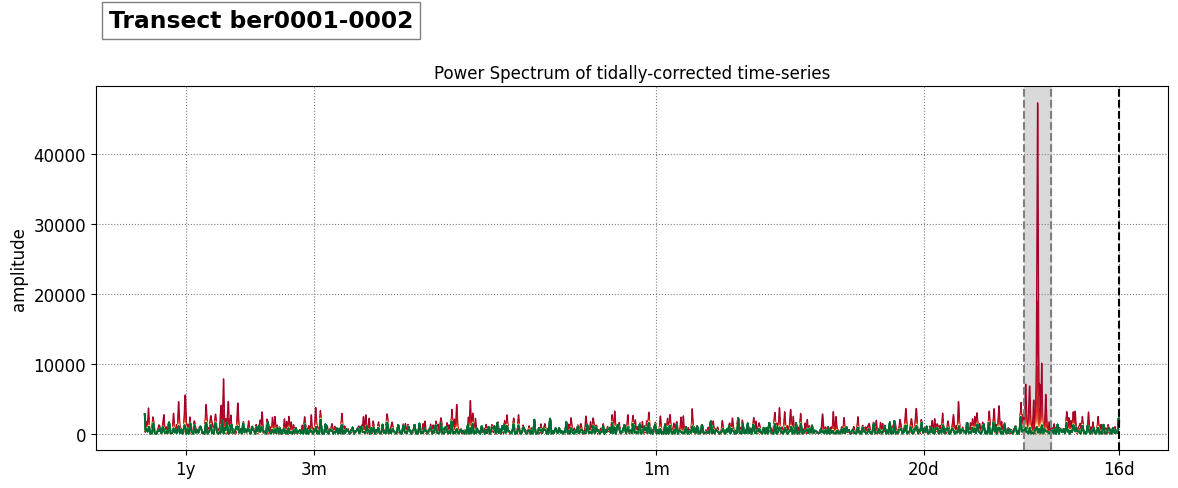

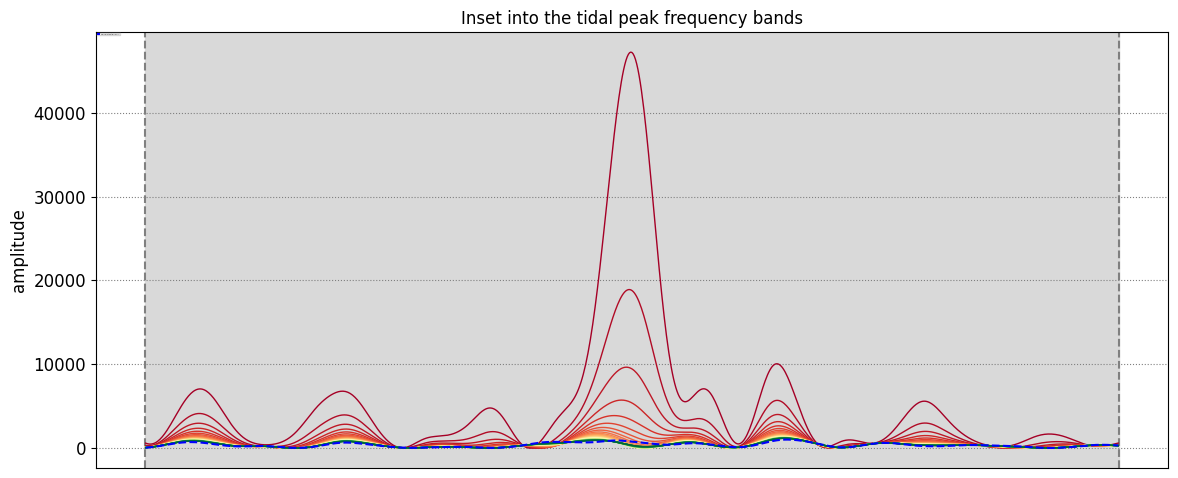

Beach slope at transect ber0001-0002: 0.200 (0.1175 - 0.2000)


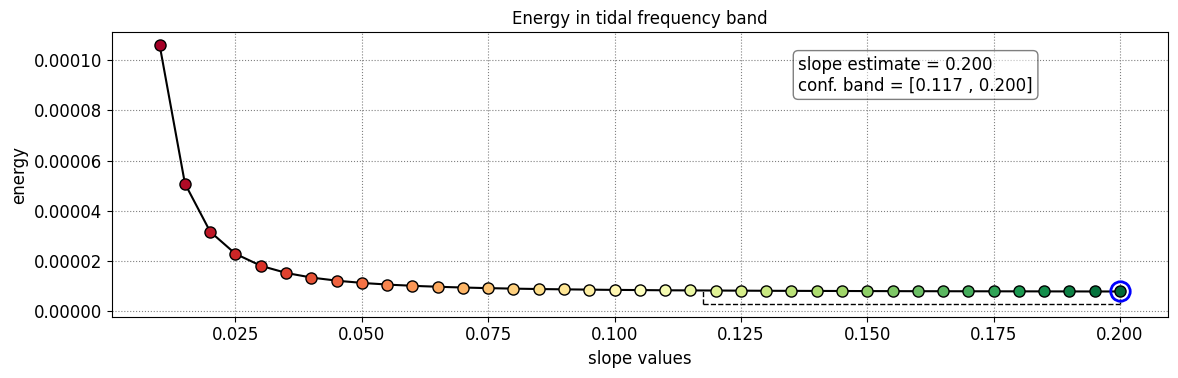

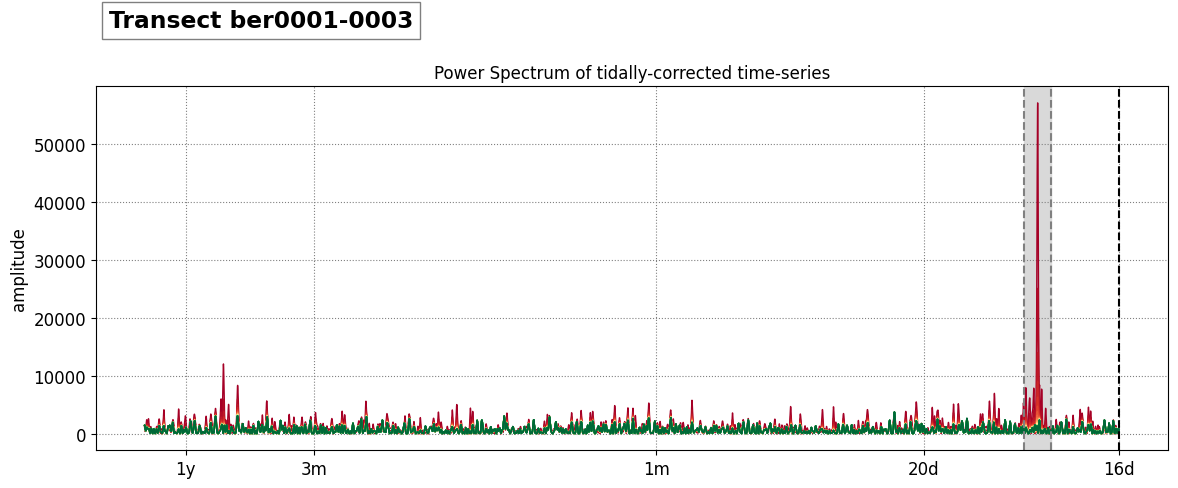

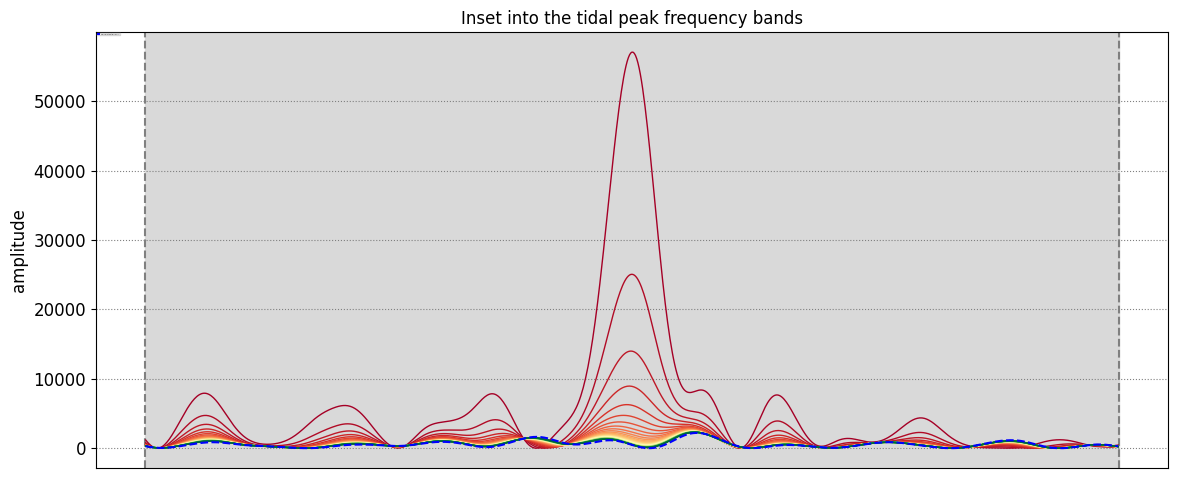

Beach slope at transect ber0001-0003: 0.200 (0.1259 - 0.2000)


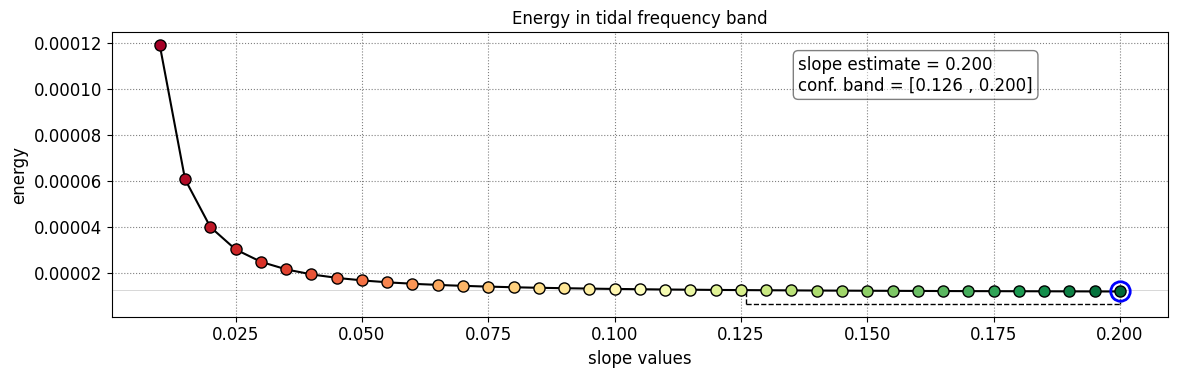

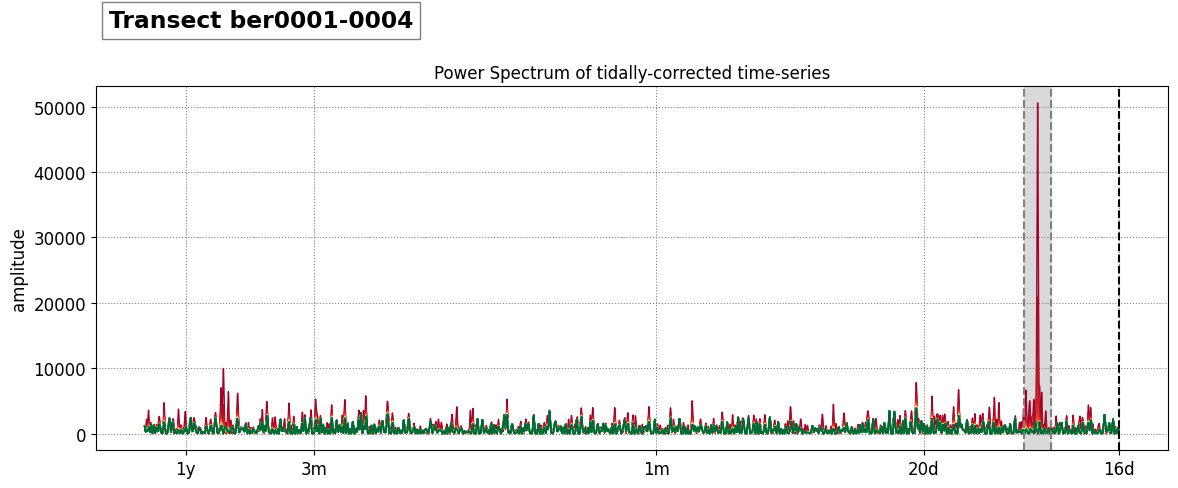

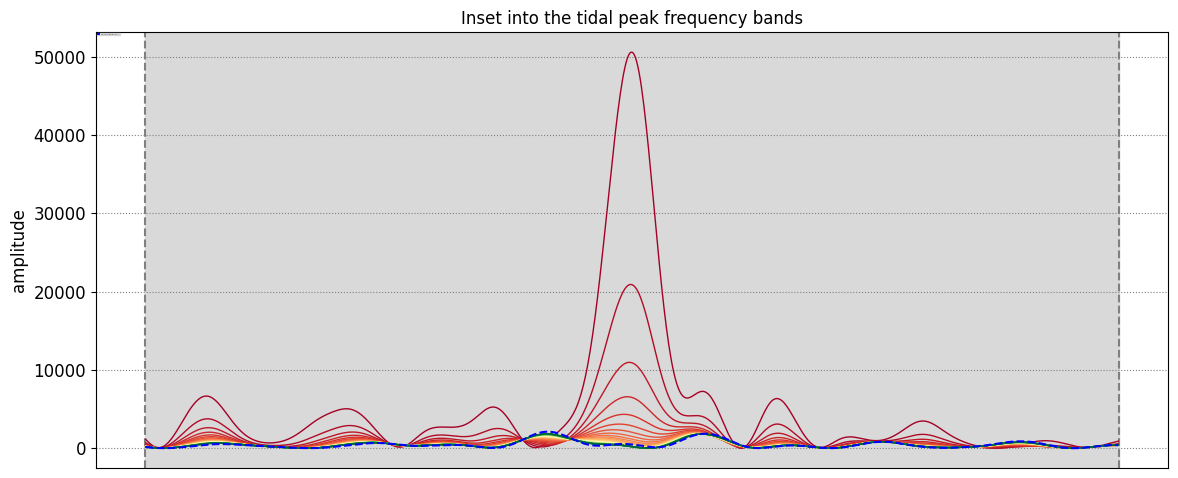

Beach slope at transect ber0001-0004: 0.200 (0.1002 - 0.2000)


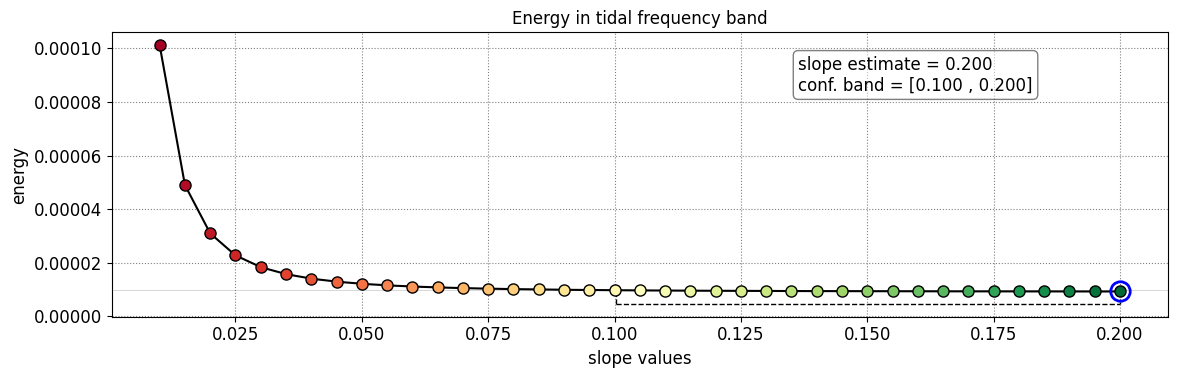

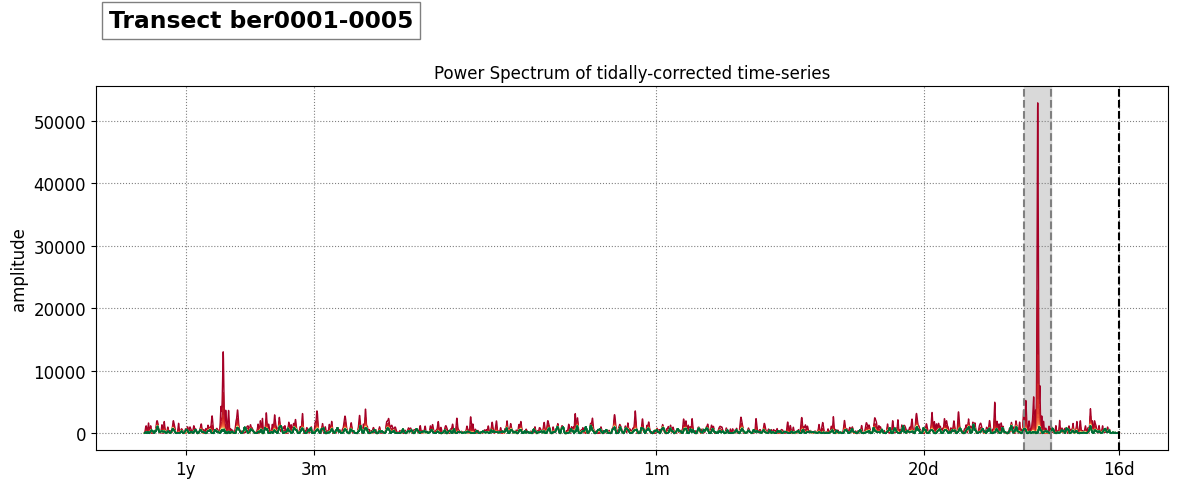

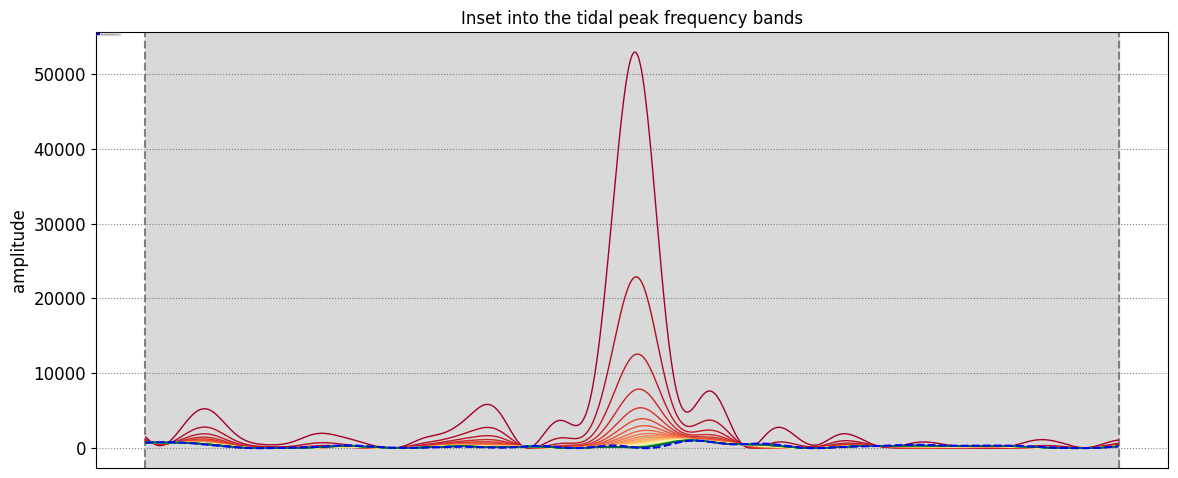

Beach slope at transect ber0001-0005: 0.175 (0.0911 - 0.2000)


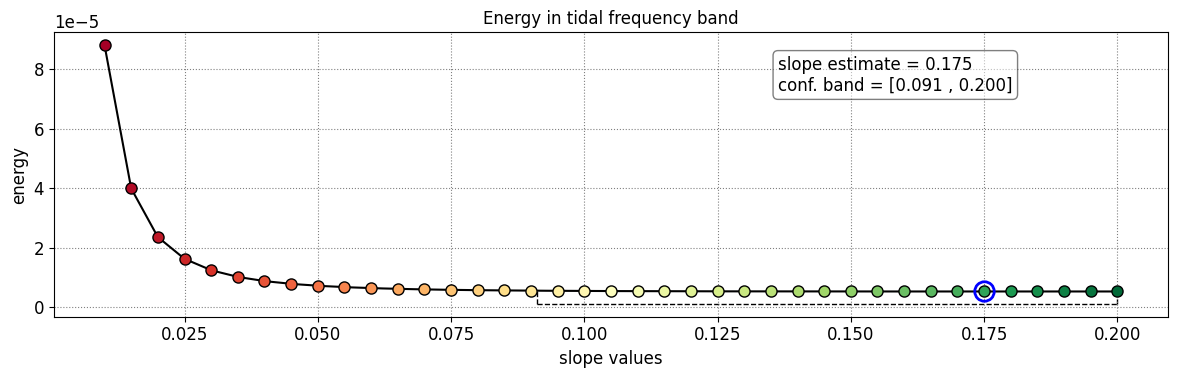

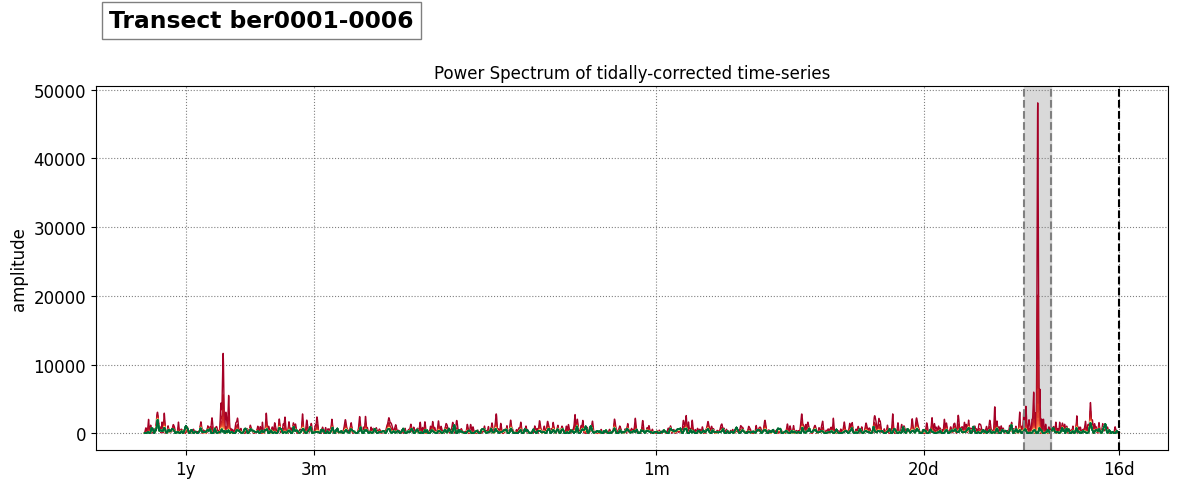

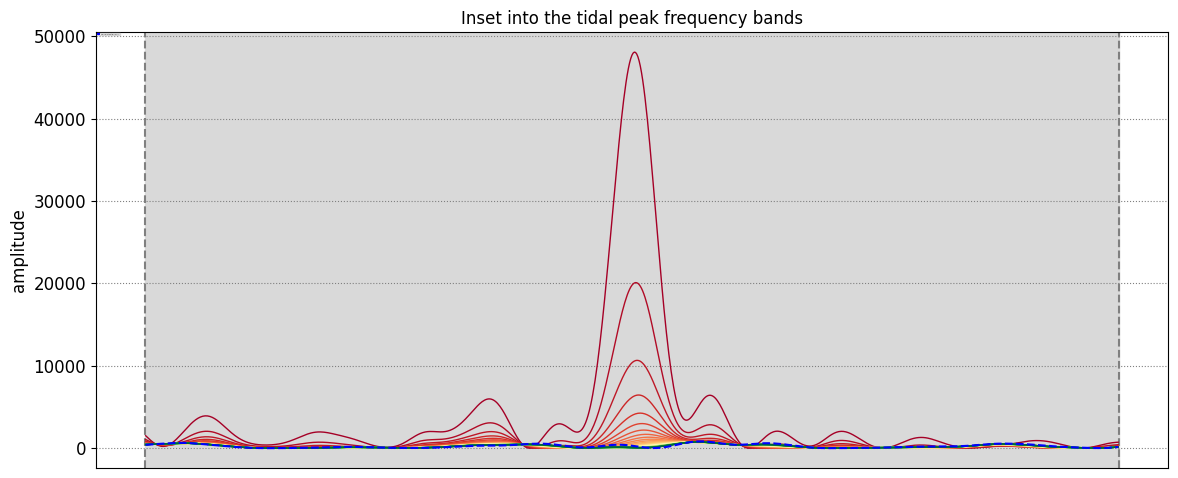

Beach slope at transect ber0001-0006: 0.110 (0.0717 - 0.2000)


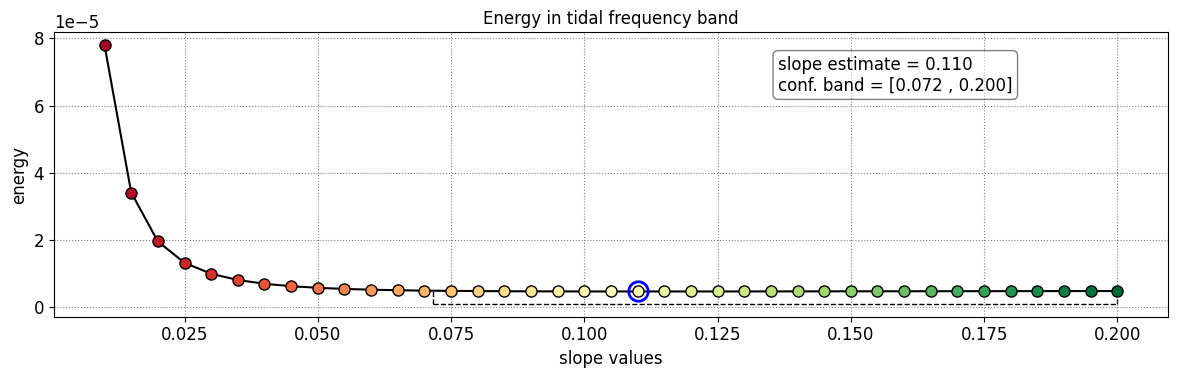

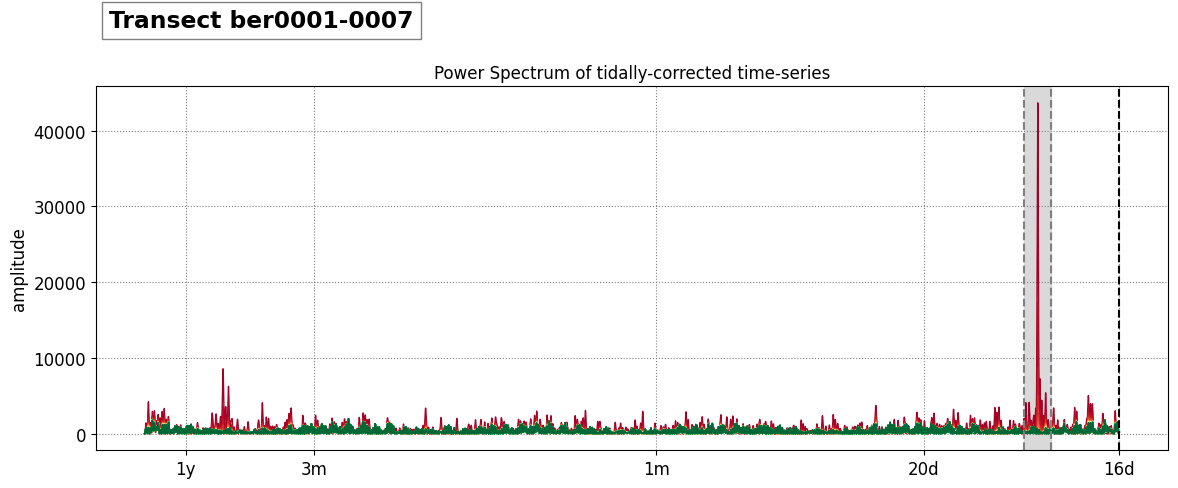

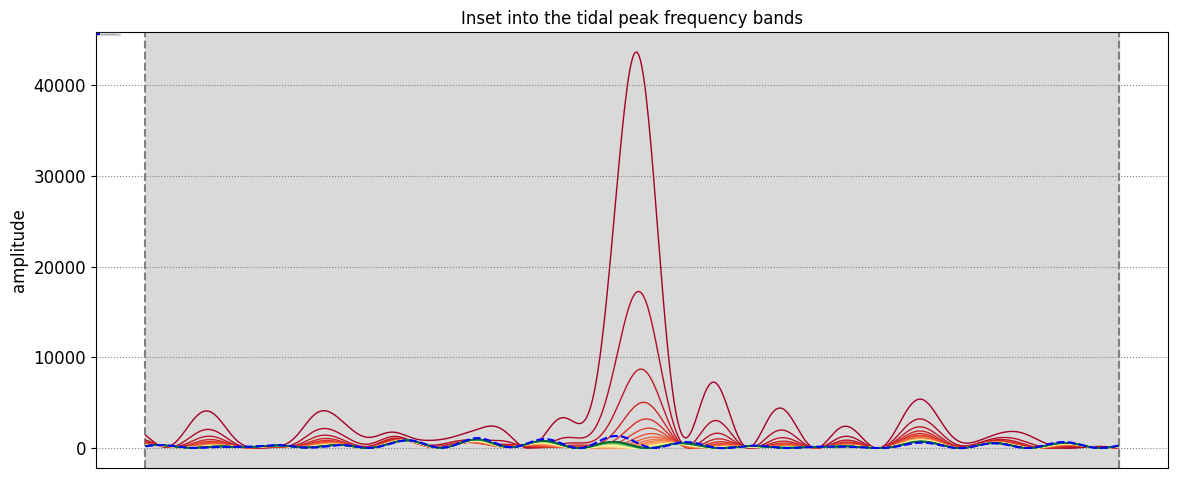

Beach slope at transect ber0001-0007: 0.090 (0.0599 - 0.1718)


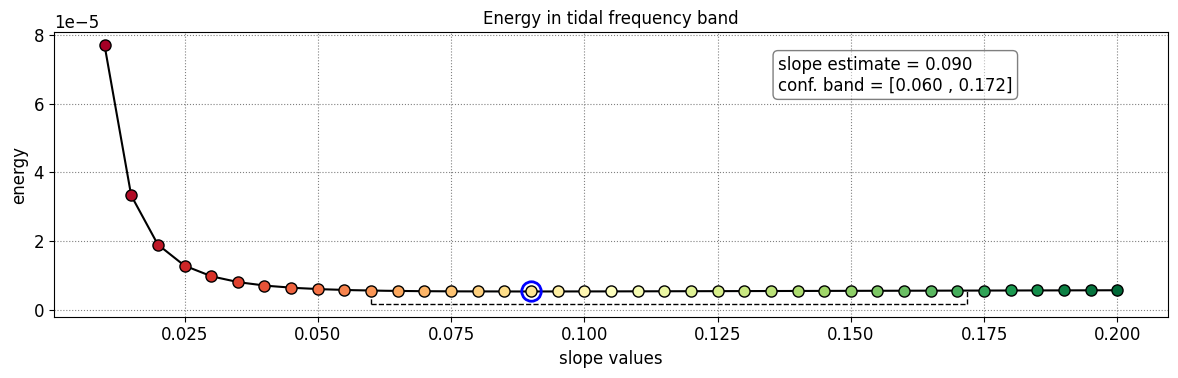

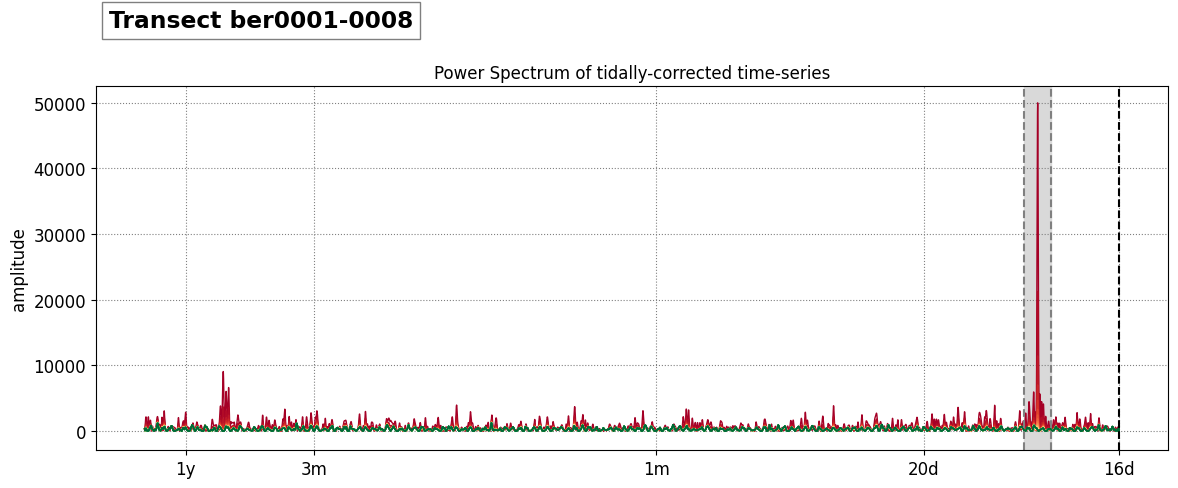

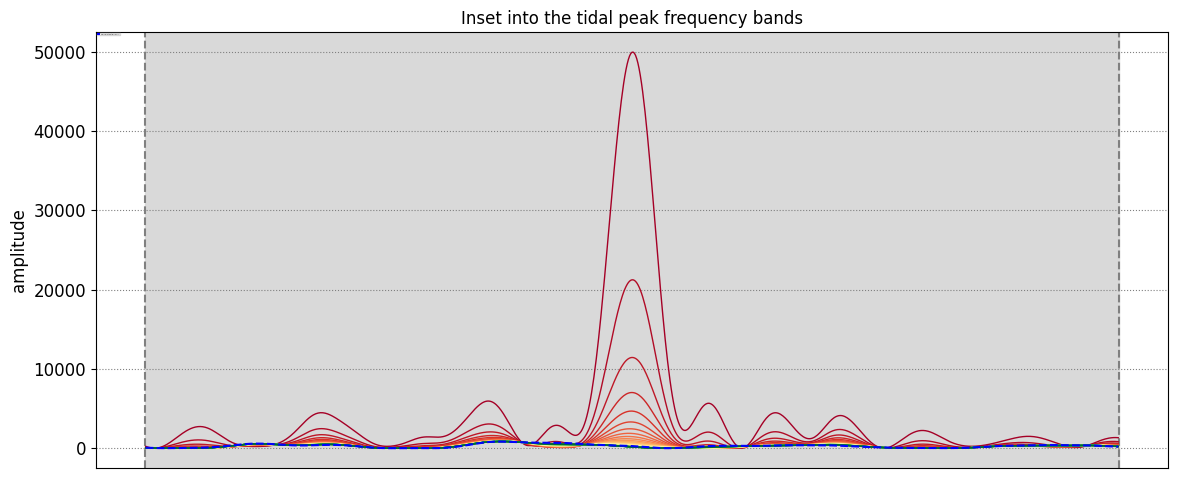

Beach slope at transect ber0001-0008: 0.170 (0.0884 - 0.2000)


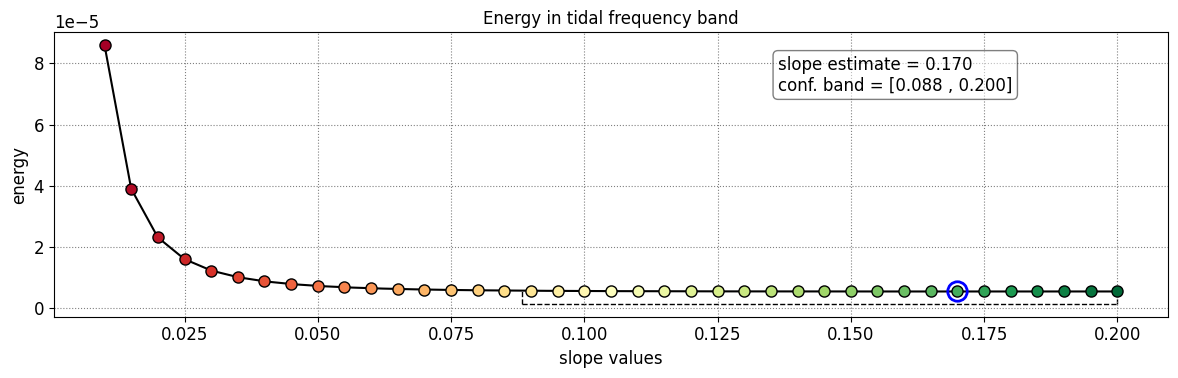

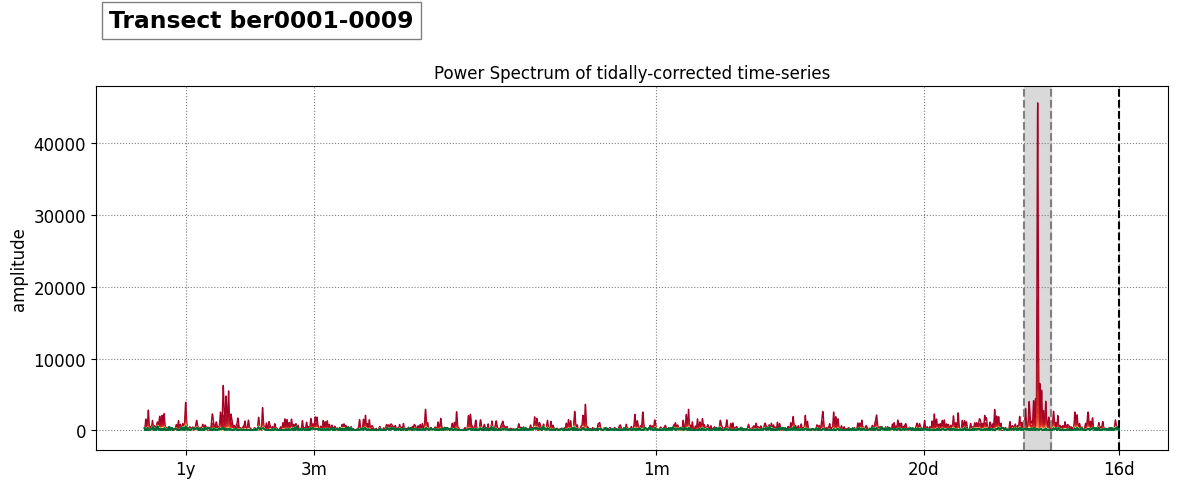

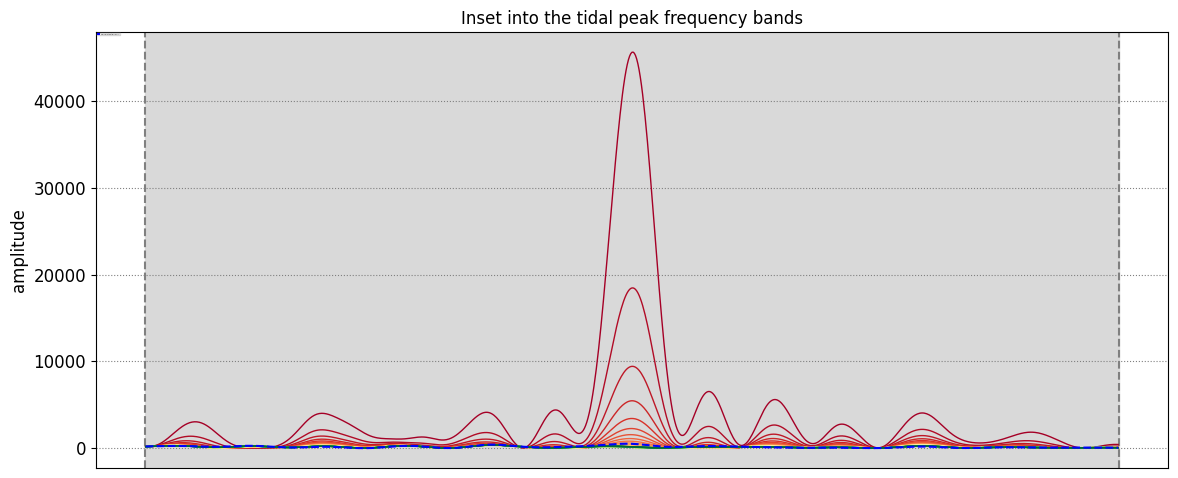

Beach slope at transect ber0001-0009: 0.135 (0.0894 - 0.2000)


In [131]:
# estimate beach-face slopes along the transects
slope_est, cis = dict([]), dict([])
for key in df.keys():
      # remove NaNs
      idx_nan = np.isnan(df[key])
      dates = [df.index[_] for _ in np.where(~idx_nan)[0]]
      tide = tides.tide.to_numpy()[~idx_nan]
      composite = df[key][~idx_nan]
      # apply tidal correction
      tsall = SDS_slope.tide_correct(composite,tide,beach_slopes)
      title = 'Transect %s'%key
      SDS_slope.plot_spectrum_all(dates,composite,tsall,settings_slope, title)
      plt.show()
      slope_est[key],cis[key] = SDS_slope.integrate_power_spectrum(dates,tsall,settings_slope)
      print('Beach slope at transect %s: %.3f (%.4f - %.4f)'%(key, slope_est[key], cis[key][0], cis[key][1]))

In [132]:
transects = gpd.read_file("transects_extended.geojson").set_index("id")
transects.beach_slope.update(slope_est)
transects.cil.update({k: v[0] for k,v in cis.items()})
transects.ciu.update({k: v[1] for k,v in cis.items()})
display(transects[transects.index.isin(slope_est.keys())])
transects.to_file("transects_extended.geojson")

site_id  orientation  along_dist  along_dist_norm  beach_slope  \
id                                                                             
ber0001-0000  ber0001          NaN         NaN              NaN        0.200   
ber0001-0001  ber0001          NaN         NaN              NaN        0.185   
ber0001-0002  ber0001          NaN         NaN              NaN        0.200   
ber0001-0003  ber0001          NaN         NaN              NaN        0.200   
ber0001-0004  ber0001          NaN         NaN              NaN        0.200   
ber0001-0005  ber0001          NaN         NaN              NaN        0.175   
ber0001-0006  ber0001          NaN         NaN              NaN        0.110   
ber0001-0007  ber0001          NaN         NaN              NaN        0.090   
ber0001-0008  ber0001          NaN         NaN              NaN        0.170   
ber0001-0009  ber0001          NaN         NaN              NaN        0.135   

                 cil     ciu     trend  n_points  n_points_nonan  r2_score  \
id                                                                           
ber0001-0000  0.1130  0.2000 -0.056208     232.0            69.0  0.002363   
ber0001-0001  0.0802  0.2000 -0.078000     232.0            71.0  0.004105   
ber0001-0002  0.1175  0.2000 -0.018693     232.0            71.0  0.000215   
ber0001-0003  0.1259  0.2000  0.206748     232.0            72.0  0.023399   
ber0001-0004  0.1002  0.2000  0.167038     232.0            72.0  0.013311   
ber0001-0005  0.0911  0.2000  0.139066     232.0            71.0  0.014240   
ber0001-0006  0.0717  0.2000  0.151685     232.0            71.0  0.017228   
ber0001-0007  0.0599  0.1718  0.071970     232.0            70.0  0.004316   
ber0001-0008  0.0884  0.2000 -0.269111     232.0            71.0  0.055752   
ber0001-0009  0.0894  0.2000 -0.350871     232.0            71.0  0.069980   

                   mae        mse      rmse   intercept ERODIBILITY  \
id                                                                    
ber0001-0000  4.375736  27.222509  5.217519  170.512247        None   
ber0001-0001  4.250217  30.419051  5.515347  163.856663        None   
ber0001-0002  4.455130  33.485554  5.786670  161.618501        None   
ber0001-0003  4.286765  37.474085  6.121608  157.194883        None   
ber0001-0004  4.518156  43.443083  6.591137  158.325913        None   
ber0001-0005  3.839382  27.655792  5.258877  157.233840        None   
ber0001-0006  4.037084  27.113502  5.207063  154.499954        None   
ber0001-0007  3.556516  24.891431  4.989131  158.660779        None   
ber0001-0008  3.564831  25.338244  5.033711  170.540171        None   
ber0001-0009  4.379646  33.798802  5.813674  171.836844        None   

                                                       geometry  
id                                                               
ber0001-0000  LINESTRING (-64.8718 32.30266, -64.87371 32.30...  
ber0001-0001  LINESTRING (-64.87159 32.30279, -64.8735 32.30...  
ber0001-0002  LINESTRING (-64.87138 32.30293, -64.87328 32.3...  
ber0001-0003  LINESTRING (-64.87116 32.30306, -64.87307 32.3...  
ber0001-0004  LINESTRING (-64.87095 32.3032, -64.87286 32.30...  
ber0001-0005  LINESTRING (-64.87074 32.30333, -64.87265 32.3...  
ber0001-0006  LINESTRING (-64.87053 32.30347, -64.87243 32.3...  
ber0001-0007  LINESTRING (-64.87031 32.3036, -64.87222 32.30...  
ber0001-0008  LINESTRING (-64.86968 32.30425, -64.87252 32.3...  
ber0001-0009  LINESTRING (-64.86956 32.30445, -64.8724 32.30...

In [133]:
# remove outliers in the time-series (coastal despiking)
settings_outliers = {'max_cross_change':   40,             # maximum cross-shore change observable between consecutive timesteps
                     'otsu_threshold':     [-.5,0],        # min and max intensity threshold use for contouring the shoreline
                     'plot_fig':           True,           # whether to plot the intermediate steps
                    }
cross_distance = SDS_transects.reject_outliers(cross_distance,output,settings_outliers)

ber0001-0000  - outliers removed: 9
ber0001-0001  - outliers removed: 10
ber0001-0002  - outliers removed: 11
ber0001-0003  - outliers removed: 14
ber0001-0004  - outliers removed: 15
ber0001-0005  - outliers removed: 9
ber0001-0006  - outliers removed: 7
ber0001-0007  - outliers removed: 9
ber0001-0008  - outliers removed: 5
ber0001-0009  - outliers removed: 4


dates  ber0001-0000  ber0001-0001  ber0001-0002  \
0   1999-08-14 14:45:41+00:00    166.957854    157.543671    154.316762   
1   2000-01-05 14:45:38+00:00    168.972924    164.601998    164.573157   
2   2000-03-25 14:45:24+00:00    166.493552    160.566184    158.550023   
3   2000-06-13 14:44:40+00:00    180.067928    167.353305    166.588879   
4   2000-06-29 14:44:28+00:00    176.651299    175.546546    172.289717   
..                        ...           ...           ...           ...   
232 2025-06-26 14:52:33+00:00           NaN           NaN           NaN   
233 2025-07-12 14:52:36+00:00    166.558357    154.389590    157.369472   
234 2025-07-20 14:52:39+00:00    160.175137    151.821749    156.319454   
235 2025-07-28 14:52:42+00:00    159.418594    151.940501    156.111997   
236 2025-08-05 14:52:46+00:00    182.882891    181.716580    177.195632   

     ber0001-0003  ber0001-0004  ber0001-0005  ber0001-0006  ber0001-0007  \
0      159.880179    160.588736    163.650771    160.900300    163.561357   
1      164.934089    165.384643    164.978498    159.965338    160.364535   
2      159.832041    160.399286    161.075675    161.094865    162.763031   
3      165.411685    166.055961    164.052441    157.855060    158.194403   
4      162.643205    160.935523    155.582829    155.645460    159.217829   
..            ...           ...           ...           ...           ...   
232    160.010970    160.017282    161.454150    161.853349    162.040623   
233    165.037843    169.814531    166.743690    164.254068    169.275762   
234    156.701725    157.457152    161.426974    163.142729    165.209372   
235    156.346177    158.251083    160.484856    166.815120    167.489687   
236    177.199653    179.119886    172.376446    170.157983    159.926803   

     ber0001-0008  ber0001-0009  
0      168.422382    164.492849  
1      169.858853    174.570434  
2      168.804478    170.004867  
3      165.514970    162.445849  
4      169.265522    170.920173  
..            ...           ...  
232    154.054591    153.253497  
233    166.332491    165.308814  
234    163.698589    159.493613  
235    155.084031    154.984263  
236    157.921315    161.041505  

[237 rows x 11 columns]

Tidally-corrected time-series of the shoreline change along the transects saved as:
data/ber0001/transect_time_series_tidally_corrected.csv


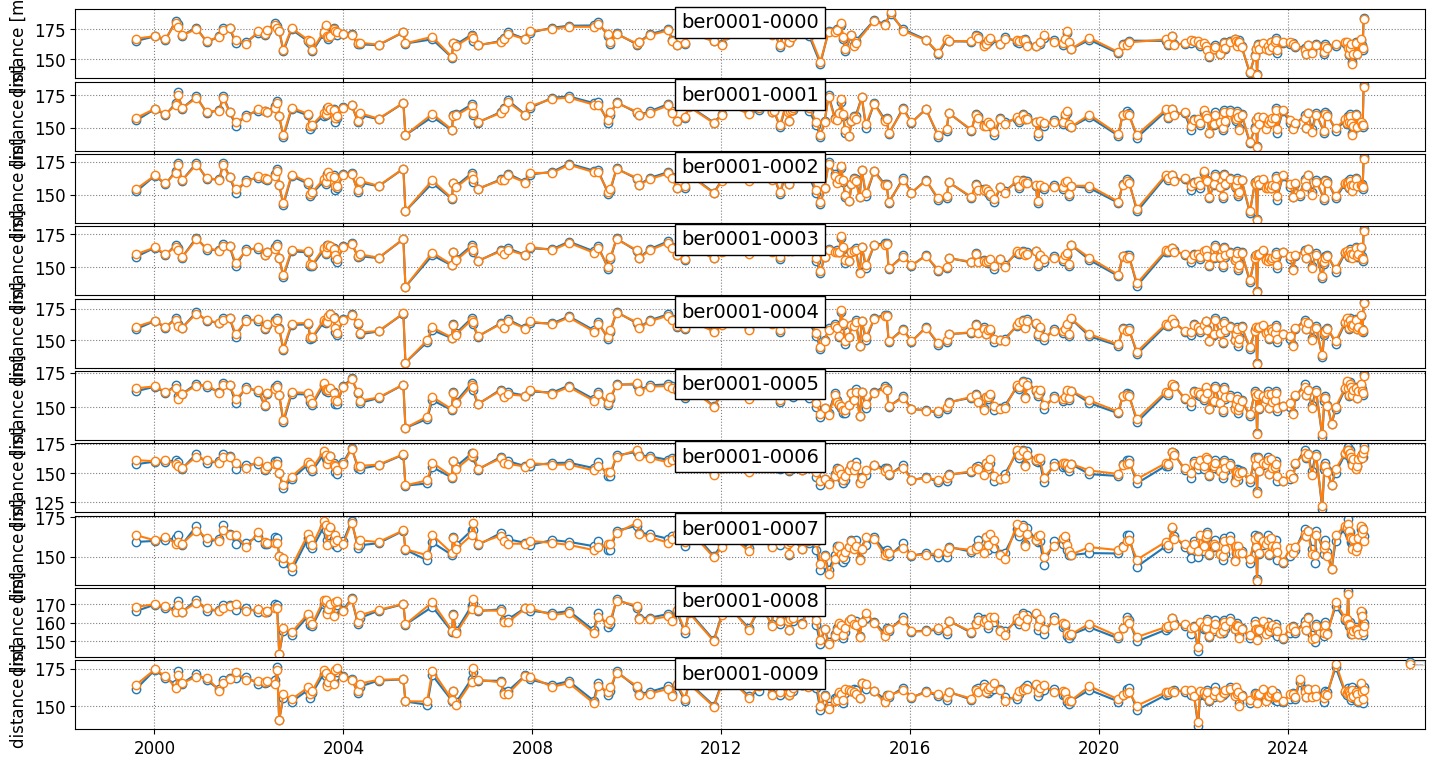

In [134]:
# tidal correction along each transect
cross_distance_tidally_corrected = {}
for key in cross_distance.keys():
    correction = (tides_sat)/slope_est[key]
    cross_distance_tidally_corrected[key] = cross_distance[key] + correction
    
# store the tidally-corrected time-series in a .csv file
out_dict = dict([])
out_dict['dates'] = dates_sat
for key in cross_distance_tidally_corrected.keys():
    out_dict[key] = cross_distance_tidally_corrected[key]
df = pd.DataFrame(out_dict)
display(df)
fn = os.path.join(filepath,'transect_time_series_tidally_corrected.csv')
df.to_csv(fn, sep=',')
print('Tidally-corrected time-series of the shoreline change along the transects saved as:\n%s'%fn)

# plot the time-series of shoreline change (both raw and tidally-corrected)
fig = plt.figure(figsize=[15,8], tight_layout=True)
gs = gridspec.GridSpec(len(cross_distance),1)
gs.update(left=0.05, right=0.95, bottom=0.05, top=0.95, hspace=0.05)
for i,key in enumerate(cross_distance.keys()):
    if np.all(np.isnan(cross_distance[key])):
        continue
    idx_nan = np.isnan(cross_distance[key])
    dates = [output['dates'][_] for _ in np.where(~idx_nan)[0]]
    chainage = cross_distance[key][~idx_nan]
    chainage_corrected = cross_distance_tidally_corrected[key][~idx_nan]
    ax = fig.add_subplot(gs[i,0])
    ax.grid(linestyle=':', color='0.5')
    ax.plot(dates, chainage, '-o', ms=6, mfc='w', label='raw')
    ax.plot(dates, chainage_corrected, '-o', ms=6, mfc='w', label='tidally-corrected')
    ax.set_ylabel('distance [m]', fontsize=12)
    ax.text(0.5,0.95, key, bbox=dict(boxstyle="square", ec='k',fc='w'), ha='center',
            va='top', transform=ax.transAxes, fontsize=14)
ax.legend()
fig.savefig(os.path.join(filepath,'%s_timeseries_corrected.jpg'%sitename),dpi=200)
fig